#### Pickleball Winner ML Classification Model
1. Simulating pickleball match data
2. Splitting data: stratified k-fold validation, train-test split 
3. Feature engineering: player stats, match conditions
4. Pipeline: preprocessing(Scaling, Feature Selection), model training
5. Model evaluation: accuracy, precision, recall, F1-score
6. Hyperparameter tuning: Grid Search, Random Search
7. Select the best model based on evaluation metrics
8. Final model evaluation and saving 

In [11]:
# Install necessary libraries
!pip install numpy pandas matplotlib scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl

In [6]:
### SIMULATING PICKLEBALL DATASET ### 
# Setting seed for reproducibility
np.random.seed(11)

def generate_pickleball_data(num_matches=200): 
    data = []

    for i in range(num_matches):
        # Player ranking: p1_rank, p2_rank
        p1_rank = round(np.random.uniform(3.0, 6.0),1)
        p2_rank = round(np.random.uniform(3.0, 6.0),1)
        # Player win rate: p1_win_rate, p2_win_rate
        p1_win_rate = round(np.random.uniform(0.4, 0.9),2)
        p2_win_rate = round(np.random.uniform(0.4, 0.9),2)
        # Court type: court_type + Weather conditons 
        court_type = np.random.choice(['indoor', 'outdoor'])
        if court_type == 'indoor': 
            weather = 'indoor_aircon'
        else: 
            weather = np.random.choice(['sunny', 'windy', 'cloudy'])
        
        # Match duration: minutes 
        duration = np.random.randint(45, 75)

        ## Determining winner: player with higher rank has a higher chance of winning 
        win_prob = 0.5 + ((p1_rank - p2_rank)*0.4) + ((p1_win_rate - p2_win_rate)*0.3)
        win_prob = max(0.01, min(0.99, win_prob))  # capping between 10% to 90%

        winner = 'Player 1' if np.random.random() < win_prob else 'Player 2'

        ## Appending match data
        data.append({ 
            'p1_rank': p1_rank,
            'p2_rank': p2_rank,
            'p1_win_rate': p1_win_rate,
            'p2_win_rate': p2_win_rate,
            'court_type': court_type,
            'weather': weather,
            'duration': duration,
            'winner': winner
        })

    return pd.DataFrame(data)




In [7]:
### SIMULATING THE PICKLEBALL DATASET ###
df = generate_pickleball_data(num_matches=200)
print(df.head(10))
# Calculate wins for each player 
win_counts = df['winner'].value_counts()
print(win_counts)

   p1_rank  p2_rank  p1_win_rate  p2_win_rate court_type        weather  \
0      3.5      3.1         0.63         0.76    outdoor         cloudy   
1      4.5      5.8         0.83         0.76     indoor  indoor_aircon   
2      5.6      3.5         0.72         0.41    outdoor         cloudy   
3      3.1      5.8         0.61         0.49    outdoor         cloudy   
4      5.1      4.8         0.43         0.64    outdoor          sunny   
5      4.8      4.7         0.87         0.89    outdoor          sunny   
6      4.2      3.1         0.50         0.64    outdoor         cloudy   
7      5.4      5.7         0.80         0.68    outdoor          windy   
8      4.3      5.2         0.43         0.41     indoor  indoor_aircon   
9      5.1      5.2         0.87         0.60    outdoor          windy   

   duration    winner  
0        69  Player 1  
1        46  Player 2  
2        56  Player 1  
3        70  Player 2  
4        50  Player 2  
5        53  Player 1  
6     

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold

x = df.drop('winner', axis=1)  # axis 1 --> columns; we want everything except 'winner' 
y = df['winner']               # because winner is our target variable

### HOLD-OUT TEST SET ### 
# setting aside 20% of dataset as final test set 
# prevents data leakage and ensures unbiased evaluation
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y, test_size =0.2, stratify=y, random_state=11
)

# checking size of datasets 
print(f"\nTOTAL MATCHES: {len(df)}")
print(f"TRAIN+VALIDATION SET: {len(x_temp)}")
print(f"HOLD-OUT TEST SET: {len(x_test)}")




TOTAL MATCHES: 200
TRAIN+VALIDATION SET: 160
HOLD-OUT TEST SET: 40


### CANDIDATE CLASSIFICATION MODELS ### 
1. Logistic Regression (Binary Classification)
2. Random Forest, 
3. Support Vector Machine 



In [13]:
### LOGISTIC REGRESSION ### 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

### PREPROCESSOR ###

# Identify column types 
num_features = ['p1_rank', 'p2_rank', 'p1_win_rate', 'p2_win_rate', 'duration']
cat_features = ['court_type', 'weather']

# Create a preprocessor to handle both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]) 


### LOGISTIC REGRESSION MODEL ###

logreg = LogisticRegression( 
    solver="lbfgs",
    max_iter=1000,
    C=1,
    class_weight=None,
    random_state=11)


### PIPELINE: PREPROCESSOR + MODEL ###

logreg_pipe = make_pipeline(preprocessor, logreg)


### STRATIFIED K-FOLD CROSS-VALIDATION ###

# using the remaining 80% (train+val) for stratified k-fold cv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
print("\nStratified K-Fold Splits:")
for fold, (train_index, val_index) in enumerate(skf.split(x_temp, y_temp)):     # issue: overwrites the x_train each time it loops, ending up with the last fold's x_train
    x_train, x_val = x_temp.iloc[train_index], x_temp.iloc[val_index]
    y_train, y_val = y_temp.iloc[train_index], y_temp.iloc[val_index]
    print(f"\nFold {fold+1}:")
    print(f"Training set: {len(x_train)} matches")
    print(f"Validation set: {len(x_val)} matches")

# Evaluation based on CV
cv_scores = cross_val_score(logreg_pipe, x_temp, y_temp, cv=skf, scoring='accuracy')
print(f"\nScores for each fold: {cv_scores.round(4)} \
      \nMean CV Accuracy: {cv_scores.mean():.4f}")




Stratified K-Fold Splits:

Fold 1:
Training set: 128 matches
Validation set: 32 matches

Fold 2:
Training set: 128 matches
Validation set: 32 matches

Fold 3:
Training set: 128 matches
Validation set: 32 matches

Fold 4:
Training set: 128 matches
Validation set: 32 matches

Fold 5:
Training set: 128 matches
Validation set: 32 matches

Scores for each fold: [0.875  0.8438 0.9375 0.875  0.75  ]       
Mean CV Accuracy: 0.8562



ROC-AUC Score on Test Set: 0.9073

--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

    Player 1       0.85      0.58      0.69        19
    Player 2       0.70      0.90      0.79        21

    accuracy                           0.75        40
   macro avg       0.77      0.74      0.74        40
weighted avg       0.77      0.75      0.74        40



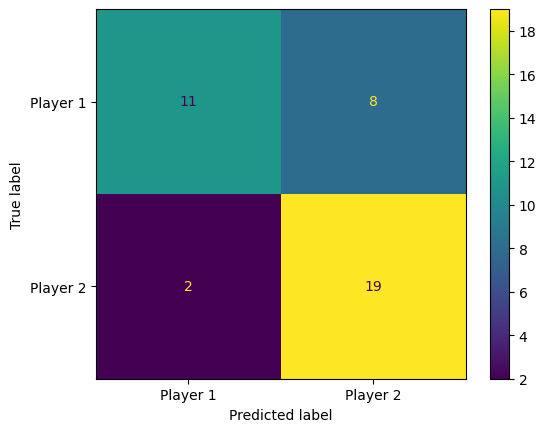

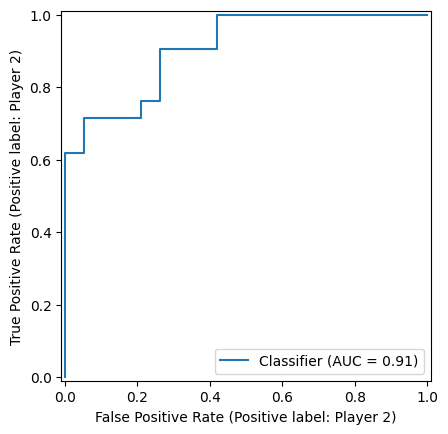

In [16]:
### FIT MODEL ON HOLD-OUT TEST SET###
logreg_pipe.fit(x_temp, y_temp)

# Prdicting winner and probabilities on hold-out test set 
y_test_prob = logreg_pipe.predict_proba(x_test)[:,1]
y_test_pred = logreg_pipe.predict(x_test)


### EVALUATION ON FINAL TEST SET ###
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder

# Confusion Matrix
labels = ['Player 1', 'Player 2']
cm = confusion_matrix(y_test, y_test_pred, labels=labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot()

# ROC-AUC Curve
le = LabelEncoder()
y_temp_bin = le.fit_transform(y_temp)    # converting labels to binary 
y_test_bin = le.transform(y_test)
auc_score = roc_auc_score(y_test, y_test_prob)
print(f"\nROC-AUC Score on Test Set: {auc_score:.4f}")
display_roc = RocCurveDisplay.from_predictions(y_test, 
                                               y_test_prob,
                                               pos_label='Player 2')
                                        

print("\n--- Final Test Set Evaluation ---")
print(classification_report(y_test, y_test_pred, target_names=['Player 1', 'Player 2']))
